# Movies dataset

This project aims to recommend movies to users based on other users' ratings and tag similarity

## About the dataset
This dataset (ml-25m) describes 5-star rating from MovieLens. It contains 25000095 ratings and 1093360 tag applications across 62423 movies. These data were created by 162541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.

it contains 4 files, which are :
- movies 
- ratings
- genome-tags
- genome-scores

---
#### Step 1 : set up 

In [2]:
%%capture

# data management
! pip install -U pandas
! pip install -U numpy

# data visualization
! pip install -U matplotlib
! pip install -U plotnine

# modeling
! pip install -U scikit-learn



In [1]:
! pip install mxnet
! pip install graphviz
! pip install -U d2l
# ! conda install -c conda-forge implicit

     |████████████████████████████████| 47.3 MB 33 kB/s s eta 0:00:01     |██████████████████▏             | 26.8 MB 808 kB/s eta 0:00:26     |████████████████████████        | 35.6 MB 2.2 MB/s eta 0:00:06
     |████████████████████████████████| 82 kB 104 kB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 2.3 MB/s eta 0:00:01     |▊                               | 204 kB 935 kB/s eta 0:00:11
     |████████████████████████████████| 5.4 MB 320 kB/s eta 0:00:01     |███████████████████             | 3.2 MB 1.2 MB/s eta 0:00:02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.6 MB 69 kB/s  eta 0:00:01    |███████████▊                    | 4.2 MB 97 kB/s eta 0:01:16
     |████████████████████████████████| 61 kB 920 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 926 kB/s eta 0:00:01
  Created wheel for numpy: filename=numpy-1.18.5-cp39-cp39-linu

import libraries

In [1]:
import os
from mxnet import gluon, np
import pandas as pd
from d2l import mxnet as d2l
import sys
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
import implicit 
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score


upload files

In [2]:
movies=pd.read_csv('movies.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


movies file contain info about 62423 movies,
- movieId : unique identifer across files
- title : movie title
- genres : pipe-separated list of movie genres

In [6]:
ratings =pd.read_csv('ratings.csv')

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [4]:
ratings.drop('timestamp',axis = 1 , inplace = True)

ratings file contain info about 25000095 ratings,
- movieId : movie unique identifer across files
- userId : user unique identifer across files
- rating : user rating out of 5 stars

In [3]:
scores =pd.read_csv('genome-scores.csv')

In [9]:
scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [4]:
tags =pd.read_csv('genome-tags.csv')

In [11]:
tags.sample(10)

,tagId,tag
947,948,spanish
313,314,doctors
1071,1072,very good
511,512,hitman
741,742,original
254,255,cool
246,247,con artists
448,449,good music
128,129,better than expected
747,748,oscar (best animated feature)


tags are distrbuted in 2 files:
- genome-tags : which includes the tags id and the tag name
- genome-scores : which includes the tage id, the movie id and the relevance between them (at scale from 0 to 1)


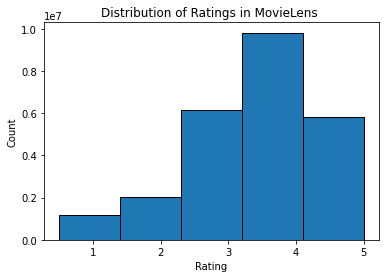

In [12]:
d2l.plt.hist(ratings['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens ')
d2l.plt.show()

some movies have a lot of ratings and some have only 1, 75% of them have 36 ratings or less

In [17]:
counts = ratings['movieId'].value_counts()
counts.describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: movieId, dtype: float64

# project building 
the project requirments :
- the user can enter a movie that they like (can i do more than 1 movie?)
- the system can show search suggestion if there's more than one movie with the same name
- the system will show the user the suggested movies based on the one they like, the recommendation will be based on other users preferances and the tag relevance between the movie and other movies
 
it is hybird recommendation system that uses collaborative-based and content-based algorithms 

In [18]:
#input movie
movieName= 'Toy Story'
movieRow = movies[movies['title'].str.contains(movieName)]
movieRow

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3021,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
14813,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
20497,106022,Toy Story of Terror (2013),Animation|Children|Comedy
22633,115875,Toy Story Toons: Hawaiian Vacation (2011),Adventure|Animation|Children|Comedy|Fantasy
22634,115879,Toy Story Toons: Small Fry (2011),Adventure|Animation|Children|Comedy|Fantasy
24062,120468,Toy Story Toons: Partysaurus Rex (2012),Animation|Children|Comedy
24064,120474,Toy Story That Time Forgot (2014),Animation|Children
59767,201588,Toy Story 4 (2019),Adventure|Animation|Children|Comedy


In [19]:
movieID = movieRow.iloc[0,0]
movieID

1

In [20]:
#look for the highest related tag
AllMovieScores = scores[scores['movieId']==movieID]
AllMovieScores.sort_values(by=['relevance'],ascending=False, inplace=True)
AllMovieScores.head()


/tmp/ipykernel_9338/3589742457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllMovieScores.sort_values(by=['relevance'],ascending=False, inplace=True)


,movieId,tagId,relevance
1035,1,1036,0.99925
243,1,244,0.99875
785,1,786,0.99575
588,1,589,0.98575
63,1,64,0.98425


In [21]:
#look for the top 30 movies that have the same tag score
topScores = scores[scores['tagId']==1036]
topScores.sort_values(by=['relevance'],ascending=False, inplace=True)
topScores.head()


/tmp/ipykernel_9338/4159392887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topScores.sort_values(by=['relevance'],ascending=False, inplace=True)


,movieId,tagId,relevance
1035,1,1036,0.99925
13605843,120474,1036,0.99925
11602515,78499,1036,0.99875
3167331,3114,1036,0.99850
13037331,106022,1036,0.99775


In [18]:
# who also likes the movie ?
UsersWhoWatched = ratings[ratings['movieId']==movieID]
UsersWhoWatched

,userId,movieId,rating
70,2,1,3.5
254,3,1,4.0
910,4,1,3.0
1152,5,1,4.0
1304,8,1,4.0
...,...,...,...
24997918,162529,1,2.0
24998300,162530,1,5.0
24998525,162533,1,4.5
24998892,162534,1,4.0


# K-nearest Neighbors

I might do this in case that i delete the least populer movies

In [22]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# ALS - Alternating Least Square 

In [10]:
y = ratings["userId"]
train_strat, test_strat = train_test_split(ratings, train_size=0.75, random_state=123, stratify=y)

In [1]:
test_strat[test_strat['userId']==14]

NameError: name 'test_strat' is not defined

In [8]:
#smaller matrices 
sparse_movie_user = sparse.csr_matrix((train_strat['rating'].astype(float), (train_strat['movieId'], train_strat['userId'])))
sparse_user_movie = sparse.csr_matrix((train_strat['rating'].astype(float), (train_strat['userId'], train_strat['movieId'])))

In [9]:
os.environ['MKL_NUM_THREADS'] = '1'

In [10]:
#Building the model
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
alpha_val = 40
data_conf = (sparse_movie_user * alpha_val).astype('double')
model.fit(data_conf)

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
userlikes = ratings[ratings['userId']==14]
userlikes

,userId,movieId,rating
2862,14,50,5.0
2863,14,293,5.0
2864,14,296,5.0
2865,14,527,5.0
2866,14,608,5.0
2867,14,1089,5.0
2868,14,1265,4.5
2869,14,2329,4.0
2870,14,2542,4.5
2871,14,2858,5.0


In [16]:
#Get Recommendations
user_id =14
recommended = model.recommend(user_id, sparse_user_movie,N=30)
recommended

[(79132, 1.0616938),
 (58559, 1.0574762),
 (318, 1.0289499),
 (99114, 1.0254543),
 (858, 1.025288),
 (109487, 1.0225201),
 (260, 1.0192983),
 (7153, 1.0174823),
 (2571, 1.0174354),
 (68157, 1.0145245),
 (59315, 1.0140648),
 (72998, 1.0105143),
 (48516, 1.0101129),
 (91529, 1.0056981),
 (5952, 1.0028492),
 (1196, 1.0017825),
 (593, 1.0015521),
 (48780, 1.0011953),
 (1198, 1.0003242),
 (356, 0.99999076),
 (1210, 0.9957795),
 (74458, 0.99526316),
 (33794, 0.99416506),
 (116797, 0.99310684),
 (7361, 0.9907767),
 (44191, 0.9888442),
 (54286, 0.98878396),
 (5618, 0.9864064),
 (4226, 0.9837461),
 (81845, 0.97788745)]

In [12]:
type(recommended)

list

In [17]:
def findMoviesName(idList):
    listofmovies = pd.DataFrame()
    for tup in idList:
        listofmovies = listofmovies.append(movies[movies['movieId']==tup[0]], ignore_index = True)

    return listofmovies

findMoviesName(recommended)

,movieId,title,genres
0,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
1,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
2,318,"Shawshank Redemption, The (1994)",Crime|Drama
3,99114,Django Unchained (2012),Action|Drama|Western
4,858,"Godfather, The (1972)",Crime|Drama
5,109487,Interstellar (2014),Sci-Fi|IMAX
6,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
7,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
8,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
9,68157,Inglourious Basterds (2009),Action|Drama|War


In [15]:
def joinRatingswithMovies(ratingList):
    return pd.merge(ratingList,movies,on='movieId')

joinRatingswithMovies(userlikes)

,userId,movieId,rating,title,genres
0,14,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1,14,293,5.0,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
2,14,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,14,527,5.0,Schindler's List (1993),Drama|War
4,14,608,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller
5,14,1089,5.0,Reservoir Dogs (1992),Crime|Mystery|Thriller
6,14,1265,4.5,Groundhog Day (1993),Comedy|Fantasy|Romance
7,14,2329,4.0,American History X (1998),Crime|Drama
8,14,2542,4.5,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller
9,14,2858,5.0,American Beauty (1999),Drama|Romance


In [ ]:
def ratingsToMovies(ratingsList):
    movieslist = pd.DataFrame()
    for index, row in ratingsList.iterrows():
        movieslist = movieslist.append(movies[row['movieId']], ignore_index = True)
    return movieslist

ratingsToMovies(userlikes)

# testing 

In [ ]:
actual = userlikes
predicted = findMoviesName(recommended)


In [ ]:
def doesItWork(actual, predicted):

    similer =actual[actual['movieId'].isin(predicted['movieId'])]
    actual.drop(similer.index, inplace = True)
    predicted.drop(similer.index, inplace = True)

    return similer,actual,predicted

In [ ]:
similer,actual,predicted = doesItWork(actual, predicted)

In [ ]:
actual

In [ ]:
similer

In [ ]:
predicted

# item-item based

minimize tags

In [8]:
def mergeTags(ListoftagsIds,scores):
    moviesIds=movies['movieId']
    tagRelev=0
    firstTag=ListoftagsIds[0]
    #find each movie
    for movie in moviesIds:
        movieOnly=scores[scores['movieId']==movie]
        #find each tag
        for tag in ListoftagsIds:
            row = movieOnly[movieOnly['tagId']==tag]
            tagRelev = tagRelev + row.iloc[0]['relevance']
            #delete the rows
            scores.drop(scores[(scores["tagId"] ==tag) & (scores['movieId']==movie)].index, inplace=True)
        #collect the mean
        tagMean = tagRelev/len(ListoftagsIds)
        #append row to the dataframe
        new_row = {'movieId':movie, 'tagId':firstTag, 'relevance':tagMean}
        scores = scores.append(new_row, ignore_index=True)
    return scores

tags that needs to be fixed

In [9]:
# 9,1980s + 13,80s 
mergeTags([9,13],scores)
#15,aardman + 16,aardman studios

#22,adapted from:book + 107,based on a book + 113,based on book + 152,book + 153,book was better

#23,adapted from:comic + 108,based on a comic + 114,based on comic + 231,comic + 232,comic book + 233,comic book adaption + 234,comics + 290,dc comics
scores.iloc(scores[(scores["tagId"] == 23 ) | (scores["tagId"] == 108)].index)
#24,adapted from:game + 112,based on a video game + 245,computer game + 1074,video game + 1075,video game adaptation + 1076,video games + 1077,videogame

#43,alien + 44,alien invasion + 45,aliens

#59,android(s)/cyborg(s) + 60,androids

#886,sci fi + 887,sci-fi + 888,science + 889,science fiction + 890,scifi + 891,scifi cult

#61,animal movie + 62,animals + 316,dog + 317,dogs + 318,dolphins + 783,pigs

#63,animated + 64,animation + 65,anime + 244,computer animation + 310,disney animated feature

#75,art + 78,artist + 79,artistic

#81,assassin + 82,assassination + 83,assassins

#87,australia + 88,australian

#115,based on true story + 110,based on a true story + 1047,true story

#1013,teen + 1014,teen movie + 1015,teenager + 1016,teenagers + 1017,teens

#127,best war films + 1096,war + 1097,war movie + 1098,wartime

#133,biographical + 134,biography

#141,black comedy + 286,dark comedy + 289,dark humor

#145,blood + 146,bloody

#798,political + 799,political corruption + 800,politics + 1119,world politics

#155,boring + 156,boring!

#176,camp + 177,campy

#208,christian + 209,christianity

#220,clever + 992,suprisingly clever + 550,intellectual + 551,intelligent + 552,intelligent sci-fi + 430,genius

#221,clones + 222,cloning

#235,coming of age + 236,coming-of-age

#240,complex + 242,complicated

#261,court + 262,courtroom + 263,courtroom drama

#278,cute + 279,cute!

# 283,dance + 284,dancing

#296,depressing + 297,depression

#323,drama + 324,dramatic + 376,family drama

#357,environment + 358,environmental

#371,fairy tale + 372,fairy tales

#384,father son relationship + 385,father-son relationship

#377,fantasy + 378,fantasy world

#387,feel good movie + 388,feel-good

#435,ghosts + 436,ghosts/afterlife + 35,afterlife
#389,fight scenes + 390,fighting

#684,music + 685,music business + 686,musical + 687,musicians

#329,drug abuse + 330,drug addiction + 331,drugs + 499,heroin + 500,heroine + 501,heroine in tight suit

#548,inspirational + 549,inspiring

#696,nazi + 697,nazis + 698,neil gaiman + 699,neo-nazis

#905,sex + 907,sexual + 909,sexuality + 911,sexy

#908,sexual abuse + 910,sexualized violence

#789,plot twist + 1049,twist + 1050,twist ending + 1051,twists & turns

#987,super hero + 988,super-hero + 989,superhero + 990,superheroes + 991,supernatural

#725,nudity + 726,nudity (full frontal - brief) + 727,nudity (full frontal - notable) + 728,nudity (full frontal) + 729,nudity (rear) + 730,nudity (topless - brief) + 731,nudity (topless - notable) + 732,nudity (topless)

#414,fun + 415,fun movie + 416,funniest movies + 417,funny + 418,funny as hell + 1071,very funny + 1058,unintentionally funny + 933,so bad it's funny + 920,silly fun + 333,dumb but funny


In [ ]:
# create binary indicators for each genre
# source: https://datascience.stackexchange.com/questions/14847/multiple-categorical-values-for-a-single-feature-how-to-convert-them-to-binary-u
mv_genres_stack = movies[movies['genres'] != '(no genres listed)'].set_index('movieId').genres.str.split('|', expand = True).stack()
mv_genres_explode = pd.get_dummies(mv_genres_stack, prefix = 'g').groupby(level = 0).sum().reset_index()
del mv_genres_stack

In [ ]:
# genre vector (binary string)
mv_genres_explode['genre_vector'] = mv_genres_explode.iloc[:,1:].values.tolist()

In [ ]:
# check out genre vector
mv_genres_explode.head(3)

In [ ]:
movies = movies.merge(mv_genres_explode[['movieId','genre_vector']], on = 'movieId', how = 'left')